# Use PRAHOM Pettingzoo Wrapper

## Introducing PRAHOM

### PRAHOM context

Given a Markovian model of an environment where agents have to collaborate to reach a common goal, solving it is just finding a right joint-policy (we can view as a set of rules for all agents) to achieve it.

*Multi-Agent Reinforcement Learning* allows converging to a joint-policy that reach the common goal. Yet a regular MARL pipeline does not cover two main concerns:
 - The "trained" joint-policy is often difficult to understand raising explainability and safety issues
 - It is difficult to satisfy some extra constraints we want sometimes in order to meet some design requirements or to help agents to converge faster within a restricted search space.

### About PRAHOM
The Partial *Relation between Agents' History and Organizational Model* (PRAHOM) is an algorithmic approach aiming to link MARL with the $\mathcal{M}OISE^+$ Organizational Model. It seeks to explicating and handling the collective emergent behavior of a regular MARL pipeline by leveraging agents' histories as a common ground between MARL and Organizational Specifications (OS).

Indeed, PRAHOM enables:
 - Training of a joint-policy under OS viewed as constraints.
 - Inferring organizational specifications from a "trained" joint-policies

#### Typical use case
For example, if you are given a set of agents acting for a football team that has to score a goal against an enemy team, you have several choices to implement the joint-policy depending on the level of constraining:
 - In the least constrained case, you may choose to let them learn the best way to organize themselves without any indication $\rightarrow$ It is regular MARL where agents may find some very empiric over-fitted solution in the beginning, and it generally takes a lot of time for a joint-policy to become more general by training on differently generated environments. In that case, some collective structured patterns may appear that are naturally fitted on the long term: roles such as goalkeeper, defender, attacker... may appear in someway.
 - In the most constrained case, you may choose to tell what agents must do in every circumstances $\rightarrow$ Indeed it is just creating a hand-crafted joint-policy and there is no learning.
 - Between these two ends, you may also choose agents to learn within a restricted search space you think to be relevant to speed up the converging towards a partially defined joint-policy $\rightarrow$ Some agents may be forced to be close to the goal cages while other may be forced to go to the front or forcing: you can expect some roles to appear to attack and some other ones to defend.
  

## PRAHOM Pettingzoo wrapper

*PRAHOM Pettingzoo Wrapper* is an additional layer to augment a Pettingzoo environment with functionalities to help a user apply PRAHOM.
Its use can be summarized according to 4 main steps as follow:

1) [optional: Determining some known OS and associate them some joint-histories]
2) [optional: Constrain agent to some of the known OS]
3) Proceed to the MARL pipeline under optionally defined constraints and avoiding over-fitting
4) Inferring the refined OS after training

**In this tutorial, we walk through these 4 steps in the simple *Moving Company* environment to highlight rather individual specifications**

## Setup

If you haven't installed the following dependencies, run:
1) Launch "create_venv.sh": it will create a "tuto_env" virtual python environment and install it as a jupyter kernel
2) Use the "tuto_env" kernel for the next steps

In [1]:
# may be required for virtual display
# !sudo apt-get install xvfb

In [2]:
!source tuto_env/bin/activate
%pip install matplotlib SuperSuit numpy pettingzoo[classic,butterfly] PyQt5 stable-baselines3 torch tensorboard --timeout 86400;
%pip install stable-baselines3[extra] --timeout 86400;
%pip install tensorboard --timeout 86400;
%pip install pyvirtualdisplay --timeout 86400;
%pip install ./../custom_envs/dist/*.tar.gz;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/julien/Documents/Thèse/omarl_experiments/custom_envs/dist/custom_envs-0.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for custom-envs: filename=custom_envs-0.1-py3-none-any.whl size=29926 sha256=181f7a0abdc37bf7fdd35eedf3901a10643b1baa0695194607fad5bba409e311
  Stored in directory: /home/julien/.cache/pip/wheels/31/e1/2f/d0dfec79a18c853c3a3dcebc84a776239348ab1df196a03c3f
Successfully built custom-envs
  Attempting uninstall: custom-envs
    Found existing installation: custom-envs 0.1
    Uninstalling custom-envs-0.1:
      Successfully uninstalled custom-envs-0.1
Note: you may need to restart the kernel to use updated packages.


Import the basic packages

In [3]:
import copy
import json
import numpy as np
import gymnasium
import pyvirtualdisplay

from dataclasses import dataclass
from enum import Enum
from pprint import pprint
from typing import Any, Callable, Dict, List, Set, Tuple, Union
from pettingzoo.utils.wrappers import BaseWrapper
from pettingzoo.utils.env import ActionType, AECEnv, AgentID, ObsType
from PIL import Image

In [4]:
# Set up a virtual display for rendering OpenAI gym / PettingZoo environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Showcase environment : *Moving Company*

### About *Moving Company* within PettingZoo


In RL/MARL, an environment represents the task or problem to be solved.

Moving Company (MCY) is a two-dimensional grid game where mover employees have to bring a package from a cell to a final cell. They are free to move up, left, down, and right in the white cells. They can pick up or drop down the package in the drop zone (yellow cells). The white cells are empty and the grey cells represent walls. The game ends when the package is dropped in the final cell. The environment is fully discrete, vectorized. Agents' observations are the 3x3 grid cells surrounding an agent.

Here, we instantiate a "turn-based" (aka Agent Environment Cycle - AEC) environment with 9 x 9 grid cells and `'rgb_aray'` mode.

We also instantiate a parallel environment with the same configuration.

In [5]:
from custom_envs.movingcompany import moving_company_v0

aec_env = moving_company_v0.env(size=9, render_mode="rgb_array")

parallel_env = moving_company_v0.parallel_env(size=9, render_mode="rgb_array")

You can render this AEC environment to see how it looks.

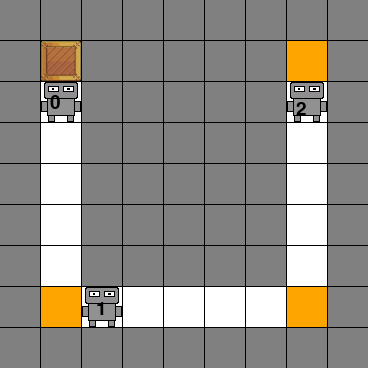

In [6]:
aec_env.reset()
Image.fromarray(aec_env.render())

Same result with parallel env

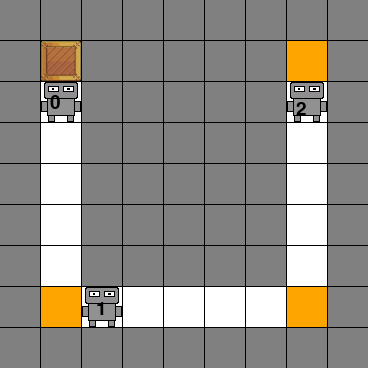

In [7]:
parallel_env.reset()
Image.fromarray(parallel_env.render())

We can list the instantiated agents in the environment (same in AEC and parallel environment)

In [8]:
print(parallel_env.agents)
aec_env.agents

['agent_0', 'agent_1', 'agent_2']


['agent_0', 'agent_1', 'agent_2']

Here, actions space is a 0 to 7 discrete space, one-hot encoding is the following:
 - 0: do nothing
 - 1: go up
 - 2: go down
 - 3: go left
 - 4: go right
 - 5: take
 - 6: drop

We can print the action space for `'agent_0'`

In [9]:
print(aec_env.action_space("agent_0"))
parallel_env.action_space("agent_0")

Discrete(7)


Discrete(7)

Here, observations space is a 3 x 3 grid (flattened) surrounding an agent, one-hot encoding for each cell is the following:
 - 0: wall
 - 1: air
 - 2: agent
 - 3: agent carrying a box
 - 4: drop zone
 - 5: box

We can print the observation space for `'agent_0'`

In [10]:
print(parallel_env.observation_space("agent_0"))
print(aec_env.observation_space("agent_0"))

MultiDiscrete([6 6 6 6 6 6 6 6 6])
MultiDiscrete([6 6 6 6 6 6 6 6 6])


In the AEC environment, agents apply their actions one after one in a cyclic way

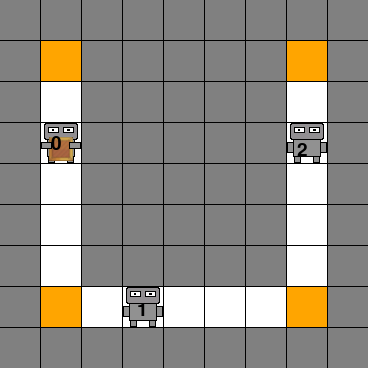

In [11]:
aec_env.reset()

# First step
aec_env.step(5) # 'agent_0' takes the box
aec_env.step(4) # 'agent_1' goes right
aec_env.step(2) # 'agent_2' goes down

# Second step
aec_env.step(2) # 'agent_0' goes down
aec_env.step(0) # 'agent_1' does nothing
aec_env.step(0) # 'agent_2' does nothing

Image.fromarray(aec_env.render())

In AEC environment, for a given agent the `last()` methods return a 5-tuple for its turn. It is composed of:
 - the current observation
 - the reward according to its last action
 - the truncation (max iteration reached for instance)
 - the done (has the game finished?)
 - the info (here contains action masks: here `'agent_0'` cannot go left, go right, take nor drop)

In [12]:
# observation, reward, termination, truncation, info = env.last()
print(aec_env.agent_selection, "receives data for its turn:")
pprint(aec_env.last())

agent_0 receives data for its turn:
(array([0, 1, 0, 0, 3, 0, 0, 1, 0]),
 5,
 False,
 False,
 {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)})


In parallel environment, agents apply their action simultaneously at each step

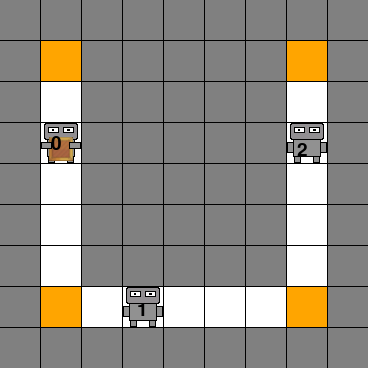

In [13]:
parallel_env.reset()

# First step
parallel_env.step({"agent_0": 5, "agent_1": 4, "agent_2": 2})

# Second step
parallel_env.step({"agent_0": 2, "agent_1": 0, "agent_2": 0})

Image.fromarray(aec_env.render())

In parallel environment, the `step()` method returns a 5-tuple composed of the data for all agent for the next step. It is composed of:
 - next observation for all agent
 - the reward for all agent
 - truncations for all agent
 - the dones for all agent
 - the infos for all agent (that may contain action masks)

In [14]:
pprint(parallel_env.step({"agent_0": 2, "agent_1": 3, "agent_2": 2}))

({'agent_0': array([0, 1, 0, 0, 3, 0, 0, 1, 0]),
  'agent_1': array([1, 0, 0, 4, 2, 1, 0, 0, 0]),
  'agent_2': array([0, 1, 0, 0, 2, 0, 0, 1, 0])},
 defaultdict(<class 'int'>, {'agent_0': 9, 'agent_1': 9, 'agent_2': 9}),
 {'agent_0': False, 'agent_1': False, 'agent_2': False},
 {'agent_0': False, 'agent_1': False, 'agent_2': False},
 {'agent_0': {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)},
  'agent_1': {'action_masks': array([1, 0, 0, 0, 0, 0, 0], dtype=int8)},
  'agent_2': {'action_masks': array([1, 1, 1, 0, 0, 0, 0], dtype=int8)}})


### Optional: 1) Defining some OS and linking them to histories

First, we may already have some known information as for what the resulting joint-policy should look like.
For instance, we may want some agents not to play some dangerous actions at some point, or we may already
known a promising organizational form to reach the goal even though it is not yet precisely defined.

This what we are going to do leveraging links between a formal description through OS of the organization and the
expected behavior through joint-histories.

#### Defining some OS

The first key concept is the Organizational Specification (OS) which represents a particular expected individual,
social or collective aspect. Organizational specifications comprise roles, links, compatibilities, goals, plans, missions, etc.

An OS is a component of the organizational model among these:
- {SS: roles, links, compatibilities, {sub-groups: SS}, role_cardinality, sub-group_cardinality}
- FS: {SCH:{goals, plans, missions, mission_to_goals, mission_to_agent_cardinality}, social_preference_order}
- DS: permissions, obligations

A single OS can be described within the organizational model with optional empty components

In [15]:
# TODO: Remove after finalizing PRAHOM package #############################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
# sys.path.append(module_path + "/prahom_wrapper")
sys.path.append(module_path)
############################################################################

from prahom_wrapper.organizational_model import organizational_model, structural_specifications

role_0_os = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0"], role_inheritance_relations=None, root_groups=None), functional_specifications=None, deontic_specifications=None)

pprint(role_0_os)

organizational_model(structural_specifications=structural_specifications(roles=['role_0'],
                                                                         role_inheritance_relations=None,
                                                                         root_groups=None),
                     functional_specifications=None,
                     deontic_specifications=None)


Here `role_0_os` defines any organization where "role_0" is available for agents.
Consequently, `role_0_os` only deals with a role so it is just a singe OS.

Note:
 - "None" value indicate any value can be accepted. It can be used if you do not know additional information regarding the ones you already provided
 - If you want to express no value, you must choose {} or [] depending on the expected value format.

In [16]:
role_01_os = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0", "role_1"], role_inheritance_relations={"role_1": ["role_0"]}, root_groups=None), functional_specifications=None, deontic_specifications=None)
pprint(role_01_os)

organizational_model(structural_specifications=structural_specifications(roles=['role_0',
                                                                                'role_1'],
                                                                         role_inheritance_relations={'role_1': ['role_0']},
                                                                         root_groups=None),
                     functional_specifications=None,
                     deontic_specifications=None)


Here `role_01_os` defines any organization where "role_0" and "role_1" are available for agents and we provide a known information
about these roles which is "role_1" inherits from "role_0".
If you had not do it, you could have let it to "None" and it would be then possible to infer it later.

#### Defining some joint-histories

The second key concept is the joint-history...
Let's recap:
- for an agent, a policy associates an observation to an action for an agent to reach a goal.
- for an agent, a history is a tuple describing sequentially all the observation-action at each step until the end of an episode
- for several agents, a joint-policy associates all the agents' observation to the agents' actions at each step enabling them to
    collectively reach their goal. It can be seen as a tuple of policies or a relation taking a vector of observation and associating
    a vector of actions.
- for several agents, a joint-history is a tuple of the agents' histories.

An observation and an action are simple objects whose type is user's responsibility

In [17]:
from prahom_wrapper.history_model import observation, action

obs1: observation = np.array([1, 0, 0, 4, 2, 1, 0, 0, 0])
act1: action = 4

([(['#any_obs', '#any_act'], ('1', '*')), (['o01', 'a01'], ('0', '*')), (['#any_obs', '#any_act'], ('1', '*'))], ('1', '*'))


Due to some complex observation or action types, we also define associated string shortcuts `action_label` and `observation_label`

In [18]:
from prahom_wrapper.history_model import observation_label, action_label

obs_label1: observation_label = "o01"
act_label1: action_label = "a1"

Users are required to define a mapping from any used label to its corresponding object

In [19]:
label_to_obj: Dict[Union[observation_label, action_label], object] = {
    "a0": 0,
    "a1": 1,
    "a2": 2,
    "a3": 3,
    "a4": 4,
    "a5": 5,
    "a6": 6,

    "o01": np.array([0, 1, 0, 0, 2, 0, 0, 1, 0]),  # 0 -> 1
    "o02": np.array([0, 5, 0, 0, 2, 0, 0, 1, 0]),  # 1 -> 5
    "o03": np.array([0, 4, 0, 0, 3, 0, 0, 1, 0]),  # 2 -> 2
    "o04": np.array([0, 1, 0, 0, 3, 0, 0, 1, 0]),  # 2 -> 2
    "o05": np.array([0, 1, 0, 0, 3, 0, 0, 4, 1]),  # 3 -> 6
    "o06": np.array([0, 1, 0, 0, 3, 0, 0, 4, 2]),  # 3 -> 6
    "o07": np.array([0, 1, 0, 0, 2, 0, 0, 5, 1]),  # -> 0
    "o08": np.array([0, 1, 0, 0, 2, 0, 0, 5, 2]),  # -> 0
    "o09": np.array([0, 1, 0, 0, 2, 0, 0, 4, 3]),  # -> 0
    "o010": np.array([0, 1, 0, 0, 2, 0, 0, 4, 1]),  # -> 0

    "o11": np.array([1, 0, 0, 5, 2, 1, 0, 0, 0]),  # 1 -> 5
    "o12": np.array([2, 0, 0, 5, 2, 1, 0, 0, 0]),  # 1 -> 5
    "o13": np.array([1, 0, 0, 4, 3, 1, 0, 0, 0]),  # 2 -> 4
    "o14": np.array([2, 0, 0, 4, 3, 1, 0, 0, 0]),  # 2 -> 4
    "o15": np.array([0, 0, 0, 1, 3, 1, 0, 0, 0]),  # 2 -> 4
    "o16": np.array([0, 0, 0, 1, 2, 1, 0, 0, 0]),  # 0 -> 3
    "o17": np.array([0, 0, 1, 1, 3, 4, 0, 0, 0]),  # 3 -> 6
    "o18": np.array([0, 0, 2, 1, 3, 4, 0, 0, 0]),  # 3 -> 6
    "o19": np.array([0, 0, 1, 1, 2, 5, 0, 0, 0]),  # -> 0
    "o110": np.array([0, 0, 2, 1, 2, 5, 0, 0, 0]),  # -> 0
    "o111": np.array([1, 0, 0, 4, 2, 1, 0, 0, 0]),  # -> 0
    "o112": np.array([3, 0, 0, 4, 2, 1, 0, 0, 0]),  # -> 0
    "o113": np.array([0, 0, 1, 1, 2, 4, 0, 0, 0]),  # -> 0
    "o114": np.array([0, 0, 3, 1, 2, 4, 0, 0, 0]),  # -> 0

    "o21": np.array([0, 1, 0, 0, 2, 0, 1, 5, 0]),  # 2 -> 5
    "o22": np.array([0, 1, 0, 0, 2, 0, 2, 5, 0]),  # 2 -> 5
    "o23": np.array([0, 1, 0, 0, 3, 0, 1, 4, 0]),  # 3 -> 1
    "o25": np.array([0, 4, 0, 0, 2, 0, 0, 1, 0]),  # 1 -> 2
    "o26": np.array([0, 1, 0, 0, 2, 0, 1, 4, 0]),  # -> 0
    "o27": np.array([0, 1, 0, 0, 2, 0, 3, 4, 0])  # -> 0
}

A **history** is just a list of alternating `observation_label` and `action_label`

In [20]:
from prahom_wrapper.history_model import history

h1: history = ["o02", "a1", "o03", "a2", "o04", "a3", "o05"]

Users can define a set of histories using the `histories` class. It gathers several histories under the form of a specific oriented graph in a compact way. It is a convenient structure to be used for training and OS inferring.

Users can create an empty `histories` as follows:

In [21]:
from prahom_wrapper.history_model import histories

hg = histories()

We can add a `history` described exhaustively or several ones as follows

In [22]:
hg = histories()
hg.add_history(["o01", "a0", "o01", "a1", "o01", "a1", "o01", "a1", "o02"])
hg.add_histories([["o01", "a0", "o01"], ["o02", "a1", "o03"]])

We can print a graph plot representation

*Here, `ord_num_to_card` maps the crossing order number to a counter that represents the cardinality (always one for exhaustive description)*

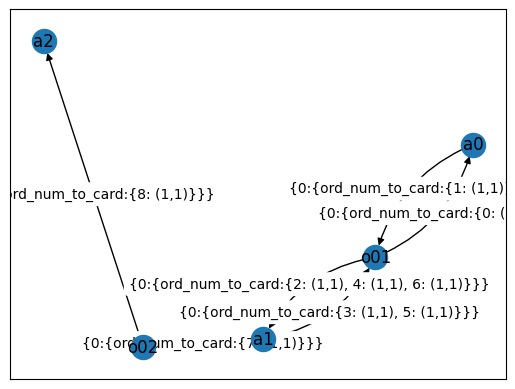

In [23]:
hg1 = histories()
hg1.add_history(["o01", "a0", "o01", "a1", "o01", "a1", "o01", "a1", "o02", "a2"])
graph_plot_rgb = hg1.generate_graph_plot(render_rgba=True, transition_data=["ord_num_to_card"])

# transition_data values is:
#  - ord_num_to_card (used for exhaustive description)

# Image.fromarray(graph_plot_rgb)

We can add a `pattern_histories` object.
The pattern used is the following:
 - sequence = **[** *sequences or labels separated by "* **,** *" or "* **|** " **](** *multiplicity_lower_bound* **, ** multiplicity_upper_bound **)**
   - sequential operator ",": label_1,label_2 $\rightarrow$ label_1 is played and then label_2
   - choice operator "|": label_1|label_2 $\rightarrow$ at least either label_1 or label_2 is played

*Here, `ord_num_to_card` maps the crossing order number to a counter that represents the cardinality*

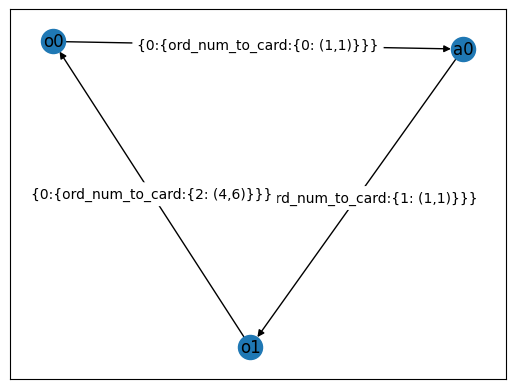

In [24]:
from prahom_wrapper.history_model import histories, pattern_histories

hg = histories()

hg.add_pattern('[o0,a0,o1](5,7)')

graph_plot = hg.generate_graph_plot(
    render_rgba=True, transition_data=["ord_num_to_card"])

# Image.fromarray(graph_plot)

Until know we only defined subsets of histories by linking known observation to action and reversely.

Sometimes, we may want to a subset of histories with unknown sub-sequences.
For instance, we may want to force 'agent_0' to take the package when it is next to itself in the superior cell and let the rest of the next sequences free to be explored.

We can do this with `pattern_histories` using special keywords:

| Keyword     | Description|
|------------|-------------------------------------------------------------|
| `'#any_act'`      | any action in that sense an agent may choose a different action among available ones|
| `'#any_obs'`      | any observation in that sense an agent may get a different observation among available ones|
| `'#any_seq'`      | any sequence in that sense it may change each time an agent cross it. It is equivalent to `'[#any_obs,#any_act](1,*)'`|
| `'#act_{`*id* `}'`      | a fixed unknown action *id* in that sense an agent would choose the same action each time it crosses to it|
| `'#obs_{` *id* `}'`      | a fixed unknown observation *id* in that sense an agent would get the same observation each time it crosses to it|

Here, each time an agent receives 'o02' (package in superior cell) it necessarily applies action 'a05' (take package).

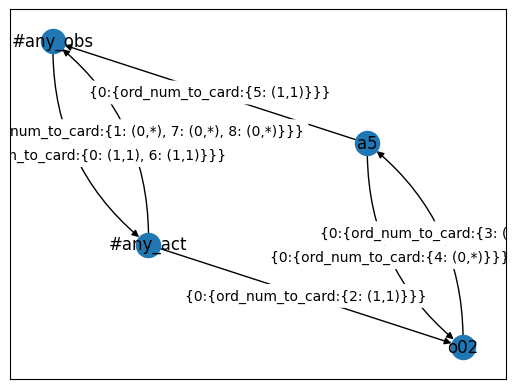

In [25]:
hg = histories()

# o02 -> superior cell is package
# a5  -> take package

hg.add_pattern('[#any_seq[o02,a5](0,*)#any_seq](1,*)')

graph_plot = hg.generate_graph_plot(
    render_rgba=True, transition_data=["ord_num_to_card"])


A **joint-history** is a tuple where each component is a single history associated with an agent. For example:

In [26]:
from prahom_wrapper.history_model import joint_history

jth: joint_history = {
    'agent_0': ['o02', 'a5', 'o03', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o06', 'a6', 'o08', 'a0', 'o09', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010','a0'],
    'agent_1': ['o111', 'a0', 'o111', 'a0', 'o111', 'a0', 'o111', 'a0', 'o111', 'a0', 'o111', 'a0', 'o112', 'a0', 'o12', 'a5', 'o14', 'a4', 'o15', 'a4', 'o15', 'a4', 'o15', 'a4', 'o15', 'a4', 'o18', 'a6', 'o110', 'a0', 'o114', 'a0', 'o113', 'a3', 'o16', 'a4', 'o113', 'a0', 'o113', 'a0', 'o113', 'a0', 'o113','a0'],
    'agent_2': ['o25', 'a0', 'o25', 'a2', 'o01', 'a2', 'o01', 'a2', 'o01', 'a2', 'o01', 'a2', 'o26', 'a0', 'o26', 'a0', 'o26', 'a0', 'o26', 'a1', 'o01', 'a2', 'o26', 'a0', 'o26', 'a0', 'o27', 'a0', 'o22', 'a5', 'a1', 'o04', 'a1', 'o04', 'a1', 'o04', 'a1', 'o04', 'a1', 'o03', 'a6', 'o02','a0']
}

Considering a subset of $n$ **joint-history**, then each agent is associated to $n$ **histories**.
So, we can consider a subset of joint-history as a **joint-histories** where each component is a subset of history or **histories**.
We can define it with a `joint_histories` object.

In [27]:
from prahom_wrapper.history_model import joint_histories

jhs = joint_histories(["agent_0","agent_1","agent_2"])
jhs.add_joint_history(jth)

#### Linking OS to joint-histories

The underlying PRAHOM's idea, is to hypothesize if there is a specific OS among the agents' implicit organization, then their
joint-histories (obtained from a same joint-policy) should  match a specific pattern accordingly. Reversely, if some joint-histories
obtained from a same joint-policy share some common features, then the agents' implicit organization should be described into OS
defined according to these common features.

Therefore, as we may already known some OS and their expected associated behaviors, we must define all of the possible joint-histories
to describe the impact of an OS.
It is important to note, the number of agent is undefined and we do not known what OS are associated to what agent.
So, when defining associated joint-histories associated to an OS, we must be careful to keep it general.

Now, we known how to define a set of histories for a single agent, we would like to define a relation between each defined OS with a relation telling how the OS impact any subset of agents regarding their histories. It can formalized as such:

$$osj: \mathcal{OS} \rightarrow \mathcal{P}(\mathcal{A}) \times \mathcal{P}(H_{joint})$$

*(with $osj$ is OS to joint-history relation, $\mathcal{OS}$ is the organizational specification set, $\mathcal{A}$ the agent set, and $H_{joint}$ the joint-history set.)*

It can be understood as for any $os \in \mathcal{OS}$, among $|\mathcal{A}|$ agents only $n_{os}$ agents can be constrained to respect $os$.
Consequently, their joint-histories would have to be in $H_{joint, os} \in \mathcal{P}(H_{joint})$ to respect $os$.


Another convenient way to see $osj$ is as a relation associating any $os \in \mathcal{OS}$ to another specific relation associating the OS with the fixed arity of $n_{os}$ agents that are constrained to:

$$osaj: \mathcal{OS} \times \mathcal{A}^{n_{os}} \rightarrow H_{joint, \mathcal{OS}}$$

*(with $osaj$ associates an OS and some implied agents to the corresponding joint-histories)*

And $osj: \mathcal{OS} \rightarrow \mathcal{A} \times osaj[\mathcal{A}^{n_{OS}} \times \mathcal{OS}]$

For instance, if an OS is just a "role", then it should be associated with relation $rh: \mathcal{R} \times \mathcal{A} \rightarrow H_{joint,\mathcal{R}}$. Here $rh("agent_0", "role_0")$ would give a joint-history where "role_0" is applied to "agent_0". Here, for the obtained joint-history only the history associated to "role_0" would be constrained to be in a history subset.

Theoretically, we may define specific relations that belong to $osaj$ for each OS such as:
  - roles: $raj(\rho, ag) = H_{joint, \mathcal{\rho}}$
  - links: $laj(l, ag_{1}, ag_{2}) = H_{joint,\mathcal{l}}$
  - compatibilities: $caj(c, ag_{1}, ag_{2}) = H_{joint, \mathcal{c}}$
  - ...

The interest for these relations is to determine automatically the maximum of OS knowledge according to a given joint-history obtained after training by comparison with known relations. We consider OS except roles depend on roles to be properly defined. Indeed, we expect users to provide roles and the maximum of OS related to them when they link OS to joint-histories.

Moreover, we only want to identify OS from joint-histories, we can restrict these relations only to roles because the rest of the OS depend on them.

We define the relation that associates a role to a joint-history using the `osj_relation` class

In [28]:
from prahom_wrapper.history_model import joint_histories
from prahom_wrapper.relation_model import osj_relation

hist = ['o02', 'a5', 'o03', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o06', 'a6', 'o08', 'a0', 'o09', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010']
hh = histories()
hh.add_history(hist)

role_0 = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0"], role_inheritance_relations=None, root_groups=None), functional_specifications=None, deontic_specifications=None)

osjh = osj_relation(["agent_0", "agent_1", "agent_2"])

# ----------------

jhs0 = joint_histories(["agent_0","agent_1","agent_2"])
jhs0.add_joint_histories({
    "agent_0": hh,
    "agent_1": None,
    "agent_2": None
})

osjh.link_os(role_0, jhs0, agents=["agent_0"])

# ----------------

jhs1 = joint_histories(["agent_0","agent_1","agent_2"])
jhs1.add_joint_histories({
    "agent_0": None,
    "agent_1": hh,
    "agent_2": None
})

osjh.link_os(role_0, jhs1, agents=["agent_1"])

# ----------------

jhs2 = joint_histories(["agent_0","agent_1","agent_2"])
jhs2.add_joint_histories({
    "agent_0": None,
    "agent_1": None,
    "agent_2": hh
})

osjh.link_os(role_0, jhs2, agents=["agent_2"])

Previous code was left for explanatory reasons. It is indeed equivalent to the following:

In [29]:
hist = ['o02', 'a5', 'o03', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o04', 'a2', 'o06', 'a6', 'o08', 'a0', 'o09', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010', 'a0', 'o010', 'a0', 'o010', 'a1', 'o01', 'a2', 'o010']
hh = histories()
hh.add_history(hist)

role_0 = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0"], role_inheritance_relations=None, root_groups=None), functional_specifications=None, deontic_specifications=None)

osjh2 = osj_relation(["agent_0", "agent_1", "agent_2"])
osjh2.link_role(role_0, hh)

Here we define 'role_0' that we associate with all possible combination of joint-histories for any agent.

### Optional: 2) Constraining agents to some OS

So far, we have defined a relation between an OS and all combinations of tuples containing the implied agents and the resulting joint-histories for all agents.

To constrain an agent to some OS, we just have to select the tuple containing the concerned agent to get the joint-history subset that any agent's history should belong to.


This can be done the following way:

In [30]:
role_agent_0_jths = osjh2.get_joint_histories(role_0, ["agent_0"])

Then, we can convert it into a `joint_policy_constraint` object to be passed for training.

In [31]:
from prahom_wrapper.policy_model import joint_policy_constraint

jpc2 = joint_policy_constraint([role_agent_0_jths])

### 3) Training under some constraints

<table>

<td style="width: 50%;border-color:#FF000000">
We consider a given MARL algorithm that iteratively converges towards a joint-policy so that the joint-policy is updated at each step until a finite horizon. By default we choose <b>Proximal Policy Optimization</b> jointly with <b>StableBaseLine3</b> and <b>Optuna</b>.

We consider that restricting the actions according to the organizational specifications at each step allows constraining the converged joint-policies to the ones that satisfy the organizational specifications. Relying on that principle we propose the algorithm presented in Algorithm 3.

The proposed algorithm fits within a regular MARL context: joint-policy $\pi_{joint,ep}$ is updated after several steps allowing to have enough joint-histories $h_{joint,ep}$ and joint-rewards as feedback $r_{joint,ep}$. The training goes on over several episodes for better training until converging to a sufficient cumulative reward regarding $s$. New training are launched until $it_{max}$ times to get more joint-policies to add in $s\pi_{joint}$ as a final result.

The proposed algorithm augments that framework by changing the way agents choose their actions to meet the expectations of the organizational specifications. Using the known relations $osh$ with agents' constraints $cons[\mathcal{A}]$, $cons\_act$ has to guess the most expected actions regarding the current $h_{joint,ep}$. In practice, a decision tree reconstructed from the $osh[cons[\mathcal{A}]]$ allows getting the expected actions by following the specific episode joint-history $h_{joint,ep}$. These expected joint-actions $a_{joint,exp}$ are to be chosen by agents.

Two modes are available to integrate these constraints:
  - **correct-mode**: Correct any unexpected action by an expected one (such as a random sample). It aims to converge faster by reducing the search space with safety guarantees. Yet, it is external to the agent's policy;
  - **penalize-mode**: Add a penalty to the reward if any wrong action has been made among agents. This mode aims to make agents "learn" to respect their constraints. Yet, no safety guarantee is ensured since agents only approximate their expected behavior.

</td>
<td style="width: 50%;border-color:#FF000000">

<center><img src="../../omarl_experiments/assets/images/algo_prahom_osh.png" alt="drawing" width="450"/></center>

</td>
</tr>
</table>



To sum up, this can done automatically the following way:

(*Note: Training may take about one up to two hours depending on your configuration*)

2024-05-10 12:06:27.660472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 12:06:27.660517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 12:06:27.661859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 12:06:27.668990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 12:06:35.568850: W tensorflow/compiler/tf2

Resuming training


/home/julien/Documents/Thèse/omarl_experiments/tutorial/tuto_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logging to ./tensorboard/PPO_23


/home/julien/Documents/Thèse/omarl_experiments/tutorial/tuto_env/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

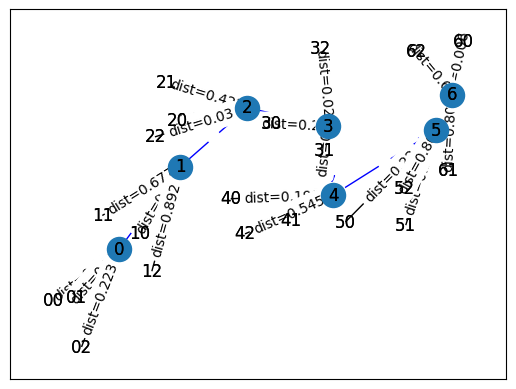

In [32]:
from custom_envs.movingcompany import moving_company_v0
from prahom_wrapper.prahom_wrapper import prahom_wrapper

env = moving_company_v0.raw_env(render_mode="human", size=10, seed=42)

roles = organizational_model(
    structural_specifications=structural_specifications(roles=["role_0", "role_1", "role2"], role_inheritance_relations=None, root_groups=None), functional_specifications=None, deontic_specifications=None)
jt_histories = joint_histories(env.possible_agents).add_joint_history(jth)

osj_rel = osj_relation(env.possible_agents).link_os(
    roles, jt_histories, env.possible_agents)

roles_agents_pc = joint_policy_constraint(
    [osj_rel.get_joint_histories(roles, env.possible_agents)])

train_env = moving_company_v0.parallel_env(
    render_mode="grid", size=10, seed=42)
eval_env = moving_company_v0.parallel_env(
    render_mode="rgb_array", size=10, seed=42)
env = prahom_wrapper(env, osj_rel, roles_agents_pc, label_to_obj)

env.train_under_constraints(
    train_env=train_env, test_env=eval_env, total_step=0)

You can see the trained model the following way:

In [33]:
env.test_trained_model()

from IPython.display import Image
Image(url='./moving_company_v0.gif')

Testing


/home/julien/Documents/Thèse/omarl_experiments/tutorial/tuto_env/lib/python3.10/site-packages/supersuit/vector/sb3_vector_wrapper.py:52: UserWarning: PettingZoo environments do not take the `render(mode)` argument, to change rendering mode, re-initialize the environment using the `render_mode` argument.
  warnings.warn(


Average reward:  1240.0
Finished


### 4) Inferring the refined OS

We can generate some OS using first the KOSIA approach and then the GOSIA one within a single command:

/home/julien/Documents/Thèse/omarl_experiments/prahom_wrapper/role_clustering.py:113: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


organizational_model(structural_specifications=structural_specifications(roles=['role_0',
                                                                                'role_1',
                                                                                'role_2'],
                                                                         role_inheritance_relations={},
                                                                         root_groups={'g1': group_specifications(roles=['role_0',
                                                                                                                        'role_1',
                                                                                                                        'role_2'],
                                                                                                                 sub_groups={},
                                                                                                          

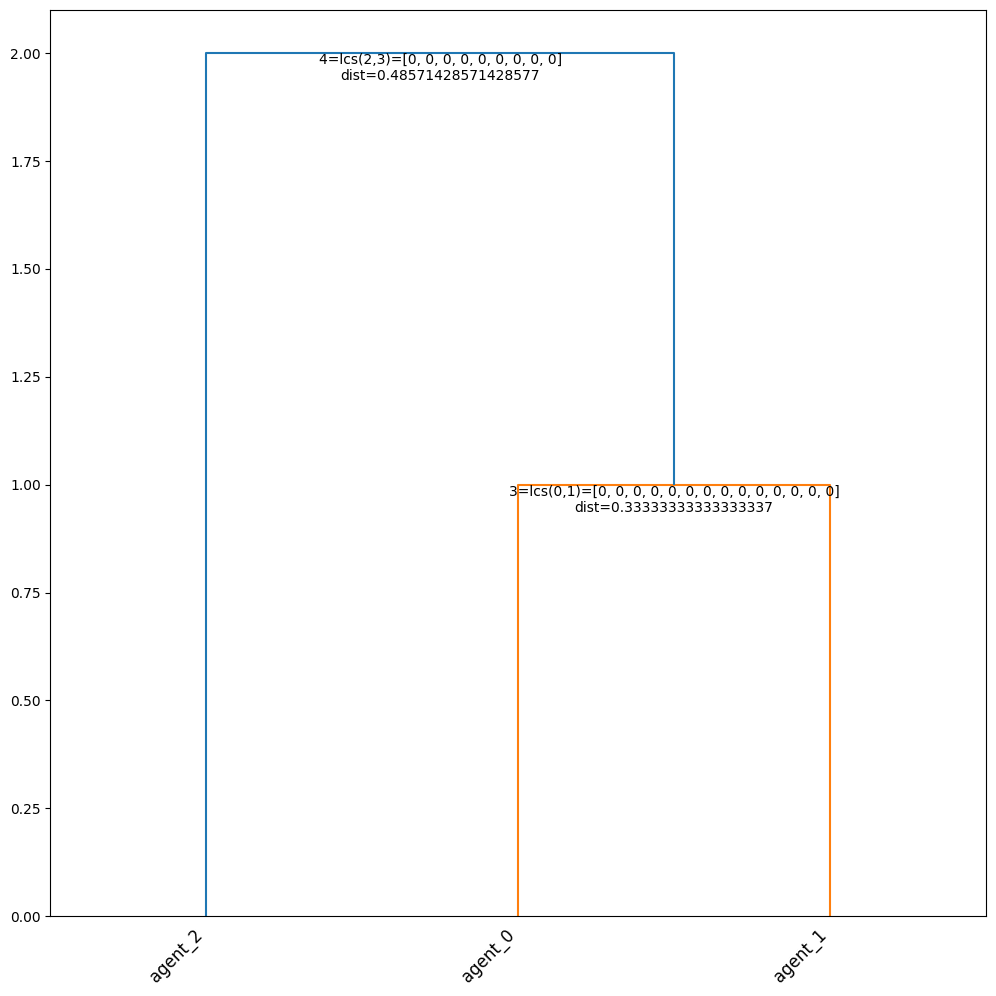

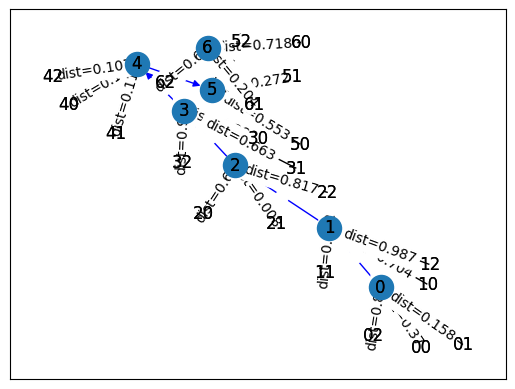

In [34]:
raw_specs = env.generate_specs()
pprint(raw_specs)

#### KOSIA: Knowledge-based OS Identification Approach

The proposed **Knowledge-based Organizational Specification Identification Approach** (**KOSIA**) aims identifying some organizational specifications thanks to the currently known relations. KOSIA is aimed to be relevant when knowledge of the relations between histories and organizational specifications is significant enough to be used generally.
For instance, we implemented KOSIA as a pattern-matching engine finding similar joint-histories to a given one hence finding the associated organizational specifications.

#### GOSIA: General OS Inferrence Approach

<center><img src="./../../omarl_experiments/assets/images/gosia_illustrative_view.png" alt="drawing" width="1000"/></center>

If it is not possible to get all known associated organizational specifications, the proposed **General Organizational Specification Inference Approach** (GOSIA) suggests an empirical approach to infer the rest of them.
GOSIA is based on some proposed definitions for each $\mathcal{M}OISE^+$ organizational specification regarding joint-histories or other organizational specifications, to use suggested specific statistical, unsupervised learning techniques to infer them incrementally. The Figure 1 summarizes the five steps of GOSIA (represented as arrow labels) that are detailed below.

##### 1) Infer roles and their inheritance

We propose a role $\rho$ is defined as a policy whose the associated histories of agents having adopted it all contain a common discontinuous sequence. We proposed a role $\rho_2$ inherits $\rho_2$ if the common discontinuous sequence of the histories associated with $\rho_2$ is also contained in the $\rho_1$'s one.
From these definitions, GOSIA leverages hierarchical sequence clustering to find the longest common discontinuous sequences among agent's histories. Results can represented as a dendrogram. It enables inferring roles and inheritance relations, their respective relation with histories, and the current agents as well.

In [35]:
Image(url='./role_clustering.png')

##### 2) Infer possible organizations

We propose an organization is linked to only one set of all instantiable roles sharing closely similar inheritance relations. Indeed, considering two trained joint-policies $H_{joint,i,s,1}$ and $H_{joint,i,s,2}$, even though both achieve a goal relying on the roles $\mathcal{R}_{ss,1}$ and $\mathcal{R}_{ss,2}$ may be far from other. For instance, their roles may not use the same responsibility distribution.
GOSIA uses a K-means algorithm to get the $q$ clusters of the vectorized $\mathcal{IR}_{i}$ considered as organizations. The roles in the same cluster share the inheritance relations of the K-means' centroid $\mathcal{IR}_j$. Indeed, they are representative general roles regarding all the similar roles adopted by agents of the same organization over all joint-histories.
For the next steps, only one chosen organization and its related joint-histories are considered. When it exists it chooses an organization close to KOSIA's one.

##### 3) Infer links and sub-groups

We propose two agents have a **social impact link** $(ag_1,ag_2, \kappa, \delta, f)$ with $h_1$ associated with $ag_1$ and $h_2$ associated with $ag_2$ if a sequence $h_{1,s}$ in $h_1$ is correlated at a $\kappa \in [0,1]$ index to another sequence $h_{2,s}$ in $h_2$ positioned at a relative delay $\delta \in [0,1]$ after the beginning of $h_{1,s}$, and these two correlated sequences are $f$ frequently present among all joint-policies.
We consider two agents to be in the same group if there is a social impact link such as $f \geq 0.9$. Considering that $\kappa$ indicates the likeliness of an agent' sequence to impact another one and that $\delta$ indicates the receiver's reactivity, we consider:
  - an acquaintance link $(ag_1,ag_2,acq)$ is defined if there is a social impact link with $\kappa \geq 0.1$, $\delta \geq 0$, $f \geq 0$;
  - a communication link $(ag_1,ag_2,com)$ is defined if there is a social impact link with $\kappa \geq 0.3$, $\delta \geq 0$, $f \geq 0$;
  - an authority link $(ag_1,ag_2,aut)$ is defined if there is a social impact link with $\kappa \geq 0.9$, $\delta \geq 0.5$, $f \geq 0$.

GOSIA uses empirical techniques to compute a graph of the social impact links between agents. Frequency enables determining clusters as agents' groups and their associated roles. It enables inferring the acquaintance, communication, and authority links between roles. From the information concerning roles associated with groups, it is possible to infer whether links are intra-group or inter-group.

##### 4) Infer goals, plans, and missions

We propose a sub-goal/goal is a set of common states that are reached following the histories of the successful agents.
For each joint-history GOSIA computes the state transition graph that is merged into a general one. Measuring the distance between two vectorized states within K-means enables finding the clusters of trajectories that some agents may follow. Then, we sampled some sets of states for each trajectory as goals. For instance, one may choose the narrowest set of states in which agents collectively seem to transition at some point to achieve their goal. Otherwise, a balanced sampling over lower variance trajectories could be made. Knowing what goal belongs to what trajectory, GOSIA infers plans for choice and sequence only.

This enables getting goals and plans at a global state but these goals could be indeed split into specific goals for each sub-group and agent. To do this, GOSIA conducts the same process replacing the states with the observations of the agents in the same sub-group for sub-groups, and observations for agents.

We propose a mission as the set of sub-goals one or several agents are achieving.
Knowing what shared goals are achieved by agents, GOSIA determines some sets of representative goals as missions.

In [36]:
Image(url='./transition_goals.png')

##### 5) Infer compatibilities, obligations, permissions, and cardinalities

We propose an obligation is when an agent playing role $\rho$ is achieving a mission's goals and no other one at some time constraints while an obligation is when an agent playing role $\rho$ may achieve some other ones at some time constraints.
GOSIA determines what agents' are associated with what mission and if they are restricted to some hence these are obligations or just permission

We propose a compatibility $(\rho_1,\rho_2)$ is defined if an agent playing a history associated with $\rho_1$ in a joint-history also plays a history associated with $\rho_2$ in another joint-history. If this change operates only in the same group, then it is intra-group. Else it is inter-group.

Finally, by counting the number of agents playing a role in each joint-history, each role's cardinality is computed. Similarly, GOSIA computes each sub-group's cardinality counting the inferred ones.


##### Perspective of complementary help from LLMs

We started experimenting **EleutherAI** **gpt-neo-2.7B** pre-trained transformer using **Transformers**' **Huggingface** library. Within **PRAHOM\_hos** it is intended to be automatically prompt-engineered with generated specific contextual descriptions of the environment, its functioning, and the $\mathcal{M}OISE^+$ organizational specifications. This prompt-engineering is to guide the answers towards three main purposes:
  - Labeling, tagging the inferred organizational specification from related joint-histories in a human-like manner;
  - Giving specific human-like textual description about each organizational specification;
  - Giving general human-like textual description of the whole organization.

Despite, being at an early stage of use in our contribution, the first results obtained with LLMs show to be a promising research focus to assist the human understanding.

In [37]:
%pip install transformers transformers[torch] transformers[tf-cpu] transformers[flax]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
from transformers import pipeline

# Load the model
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-2.7B")

action_to_description = {
    "a0": "does nothing",
    "a1": "goes up",
    "a2": "goes down",
    "a3": "goes left",
    "a4": "goes right",
    "a5": "takes package",
    "a6": "drops package"
}

action_hist_description = {agent: ", then ".join([action_to_description[label] for label in labels if label in action_to_description.keys()]) for agent, labels in jth.items()}

print(action_hist_description)

for agent in jth.keys():

    question = f'A person who {action_hist_description[agent]} is a '
    print(question)
    # Example: "A person who takes package, then goes down, then goes down, then goes down, then goes down, then goes down, then drops package, then does nothing, then does nothing, then does nothing, then does nothing, then does nothing, then goes up, then goes down, then does nothing, then goes up, then goes down, then does nothing, then does nothing, then goes up, then goes down, then does nothing is a "


    # Generate answer with prompt
    response = generator(question, max_length=400)

    # Print answer
    print("="*30)
    print(response[0]['generated_text'])